In [446]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import requests
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from autowoe import AutoWoE, ReportDeco

In [447]:
data = pd.read_csv('data_selected_final_no_na.csv')
data.head()

,funded_amnt,term,int_rate,installment,home_ownership,annual_inc,issue_d,dti,inq_last_6mths,revol_util,...,mort_acc,mths_since_recent_bc,pub_rec_bankruptcies,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,loan_condition_int,loan_condition
0,3600.0,0,13.99,123.03,1,55000.0,2015-12,5.91,1,29.7,...,1.0,4.0,0.0,2400.0,13734.0,0,0,0,0,Good Loan
1,24700.0,0,11.99,820.28,1,65000.0,2015-12,16.06,4,19.2,...,4.0,2.0,0.0,79300.0,24667.0,0,0,0,0,Good Loan
2,20000.0,1,10.78,432.66,1,63000.0,2015-12,10.78,0,56.2,...,5.0,101.0,0.0,6200.0,14877.0,0,0,0,0,Good Loan
3,35000.0,1,14.85,829.90,1,110000.0,2015-12,17.06,0,11.6,...,1.0,2.0,0.0,62500.0,18000.0,0,0,0,0,Good Loan
4,10400.0,1,22.45,289.91,1,104433.0,2015-12,25.37,3,64.5,...,6.0,4.0,0.0,20300.0,88097.0,0,0,0,0,Good Loan


In [448]:
data = data.drop(columns=['loan_condition'])

In [449]:
features_columns =  ['issue_d','funded_amnt', 'term', 'int_rate', 'installment', 'home_ownership',
       'annual_inc', 'dti', 'inq_last_6mths', 'revol_util',
       'total_acc', 'application_type', 'acc_now_delinq',
       'avg_cur_bal', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mort_acc',
       'mths_since_recent_bc', 'pub_rec_bankruptcies', 'total_bc_limit',
       'total_il_high_credit_limit', 'hardship_flag', 'disbursement_method',
       'debt_settlement_flag', 'loan_condition_int']

In [450]:
df = data[features_columns].copy()


In [453]:
OOT = df[df['issue_d'] >= '2018-06-01']
train_data = df[df['issue_d'] < '2018-06-01']
train_data.shape, OOT.shape

((1933887, 25), (256606, 25))

In [454]:
#!pip install scorecardpy
import scorecardpy as sc
from sklearn.linear_model import LogisticRegression
train, test = sc.split_df(train_data, 'loan_condition_int').values()

# woe binning ------
bins = sc.woebin(train, y='loan_condition_int')


# converting train and test into woe values
train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(test, bins)
oot_woe = sc.woebin_ply(OOT, bins)





[INFO] creating woe binning ...
Binning on 1353721 rows and 24 columns in 00:01:51
[INFO] converting into woe values ...
Woe transformating on 1353721 rows and 23 columns in 00:01:10
[INFO] converting into woe values ...
Woe transformating on 580166 rows and 23 columns in 00:00:32
[INFO] converting into woe values ...
Woe transformating on 256606 rows and 23 columns in 00:00:16


In [476]:
train_woe['funded_amnt'] = train['funded_amnt']
test_woe['funded_amnt'] = test['funded_amnt']
oot_woe['funded_amnt'] = OOT['funded_amnt']

In [477]:
X_train1= train_woe.drop(columns=['issue_d', 'loan_condition_int', 'funded_amnt'])
lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr.fit(X_train1, y_train)

LogisticRegression(C=0.9, n_jobs=-1, penalty='l1', solver='saga')

In [478]:
train_woe = train_woe[train_woe['issue_d'] >= '2017-01-01']
test_woe = test_woe[test_woe['issue_d'] >= '2017-01-01']


In [479]:
y_train = train_woe.loc[:,'loan_condition_int']
X_train = train_woe.loc[:,train_woe.columns != 'loan_condition_int']
y_test = test_woe.loc[:,'loan_condition_int']
X_test = test_woe.loc[:,train_woe.columns != 'loan_condition_int']
y_OOT = oot_woe.loc[:,'loan_condition_int']
X_OOT = oot_woe.loc[:,train_woe.columns != 'loan_condition_int']

In [480]:
X_test.columns

Index(['issue_d', 'term_woe', 'installment_woe',
       'total_il_high_credit_limit_woe', 'annual_inc_woe',
       'disbursement_method_woe', 'int_rate_woe', 'debt_settlement_flag_woe',
       'application_type_woe', 'total_acc_woe', 'mo_sin_old_il_acct_woe',
       'revol_util_woe', 'mort_acc_woe', 'funded_amnt_woe',
       'total_bc_limit_woe', 'mo_sin_old_rev_tl_op_woe',
       'pub_rec_bankruptcies_woe', 'dti_woe', 'hardship_flag_woe',
       'avg_cur_bal_woe', 'acc_now_delinq_woe', 'home_ownership_woe',
       'mths_since_recent_bc_woe', 'inq_last_6mths_woe', 'funded_amnt'],
      dtype='object')

In [481]:
X_train = X_train.drop(columns=['issue_d', 'funded_amnt'])
X_test = X_test.drop(columns=['issue_d', 'funded_amnt'])
X_OOT = X_OOT.drop(columns=['issue_d', 'funded_amnt'])

In [482]:
train_pred = lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]
oot_pred = lr.predict_proba(X_OOT)[:,1]

In [484]:

test_woe['funded_amnt']
oot_woe['funded_amnt']

,term_woe,installment_woe,total_il_high_credit_limit_woe,annual_inc_woe,disbursement_method_woe,int_rate_woe,debt_settlement_flag_woe,application_type_woe,total_acc_woe,mo_sin_old_il_acct_woe,...,total_bc_limit_woe,mo_sin_old_rev_tl_op_woe,pub_rec_bankruptcies_woe,dti_woe,hardship_flag_woe,avg_cur_bal_woe,acc_now_delinq_woe,home_ownership_woe,mths_since_recent_bc_woe,inq_last_6mths_woe
421095,-0.192224,-0.268189,0.035176,0.023802,0.0,0.768248,0.0,0.0,-0.003069,0.054613,...,0.204128,0.189131,-0.029375,0.106689,0.0,0.148228,0.0,0.179435,0.083641,-0.168842
421096,-0.192224,0.103668,-0.114453,-0.359898,0.0,-0.664712,0.0,0.0,0.073535,-0.088724,...,-0.241310,-0.170057,-0.029375,-0.037668,0.0,-0.186832,0.0,0.005093,0.083641,-0.168842
421097,0.389498,0.103668,-0.021602,0.176028,0.0,0.768248,0.0,0.0,-0.003069,0.054613,...,0.204128,0.074579,-0.029375,0.300635,0.0,0.001183,0.0,0.179435,-0.086731,0.411710
421098,0.389498,0.103668,0.035176,0.023802,0.0,0.768248,0.0,0.0,-0.003069,0.054613,...,0.204128,0.074579,-0.029375,-0.267391,0.0,0.001183,0.0,-0.161979,-0.296144,0.124853
421099,-0.192224,-0.268189,-0.071241,0.023802,0.0,-1.393737,0.0,0.0,-0.003069,-0.088724,...,-0.241310,-0.170057,-0.029375,-0.267391,0.0,-0.186832,0.0,0.179435,-0.086731,-0.168842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2086941,0.389498,0.103668,0.005689,-0.184046,0.0,0.768248,0.0,0.0,-0.003069,0.054613,...,0.055713,-0.170057,-0.029375,0.106689,0.0,-0.186832,0.0,-0.161979,-0.086731,0.411710
2086943,0.389498,0.103668,0.035176,0.176028,0.0,0.768248,0.0,0.0,-0.003069,-0.088724,...,0.204128,-0.032582,-0.029375,-0.037668,0.0,-0.459875,0.0,-0.161979,-0.296144,0.124853
2086944,-0.192224,-0.001383,0.035176,0.023802,0.0,-0.282165,0.0,0.0,-0.003069,-0.088724,...,0.204128,-0.170057,-0.029375,-0.267391,0.0,-0.186832,0.0,0.005093,-0.296144,-0.168842
2086945,0.389498,0.103668,-0.071241,0.023802,0.0,0.768248,0.0,0.0,-0.003069,0.054613,...,0.055713,0.189131,-0.029375,-0.037668,0.0,0.148228,0.0,0.179435,0.083641,0.124853


In [492]:
train_csv = X_train.copy()
train_csv['train_pred'] = train_pred
train_csv['funded_amnt'] = train_woe['funded_amnt'] 
train_csv[['funded_amnt', 'train_pred']].to_csv('train')

In [493]:
test_csv = X_test.copy()
test_csv['test_pred'] = test_pred
test_csv['funded_amnt'] = test_woe['funded_amnt']
test_csv[['funded_amnt', 'test_pred']].to_csv('OOS')

In [494]:
OOT_csv = X_OOT.copy()
OOT_csv['oot_pred'] = oot_pred
OOT_csv['funded_amnt'] = oot_woe['funded_amnt']
OOT_csv[['funded_amnt', 'oot_pred']].to_csv('OOT')

In [495]:
pd.read_csv('train').shape, pd.read_csv('OOS').shape, pd.read_csv('OOT').shape

((455180, 3), (195200, 3), (256606, 3))

In [499]:
pd.read_csv('OOT')

,Unnamed: 0,funded_amnt,oot_pred
0,749514,10000.0,0.032721
1,749515,12550.0,0.064587
2,749516,20500.0,0.225167
3,749517,24000.0,0.107968
4,749518,5000.0,0.020155
...,...,...,...
256601,1481082,23000.0,0.152978
256602,1481083,10000.0,0.114226
256603,1481084,5000.0,0.079347
256604,1481085,10000.0,0.129757


### Предикты

### Метрики качества

In [500]:
roc_auc = roc_auc_score(y_test, test_pred)
gini = (2 * roc_auc) - 1
print('ROC-AUC score: {}' .format(roc_auc))                
print('Gini score: {}'.format(gini))

ROC-AUC score: 0.6948024837366878
Gini score: 0.3896049674733757


In [501]:
roc_auc = roc_auc_score(y_OOT, oot_pred)
gini = (2 * roc_auc) - 1
print('ROC-AUC score: {}' .format(roc_auc))                
print('Gini score: {}'.format(gini))

ROC-AUC score: 0.6924482156285204
Gini score: 0.38489643125704087


### Оптимизируем трешхолд для повышения f1-score 

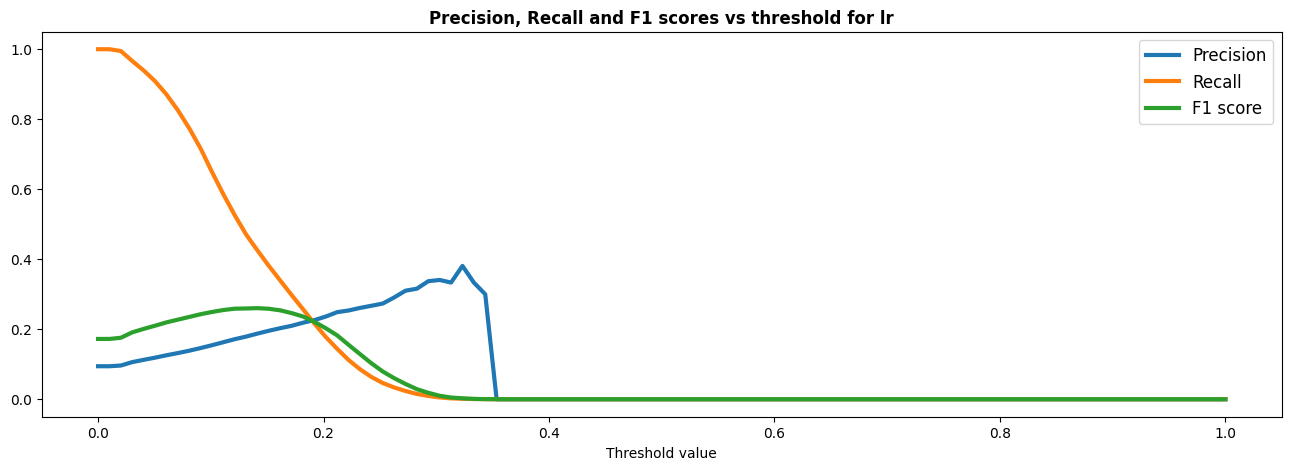

In [416]:
scores = lr.predict_proba(X_test)[:,1]


tr = np.linspace(0, 1, 100)

p = np.zeros_like(tr)
r = np.zeros_like(tr)
f = np.zeros_like(tr)

for k, x in enumerate(tr):

    y_pred = scores >= x

    p[k] = precision_score(y_test, y_pred)
    r[k] = recall_score(y_test, y_pred)
    f[k] = f1_score(y_test, y_pred)


fig = plt.figure(figsize=(16, 5))

plt.plot(tr, p, linewidth=3)
plt.plot(tr, r, linewidth=3)
plt.plot(tr, f, linewidth=3)

plt.title("Precision, Recall and F1 scores vs threshold for lr", weight="bold")

plt.xlabel("Threshold value")

plt.legend(['Precision', 'Recall', 'F1 score'], fontsize=12)

plt.show()

In [428]:
y_pred_new_threshold = (lr.predict_proba(X_test)[:,1]>=0.18).astype(int)
roc_auc = roc_auc_score(y_test, y_pred_new_threshold)
gini = (2 * roc_auc) - 1
print('ROC-AUC score: {}' .format(roc_auc))                
print('Gini score: {}'.format(gini))
print('F1-score: {}'.format(f1_score(y_test, y_pred_new_threshold)))

ROC-AUC score: 0.582334115376203
Gini score: 0.1646682307524061
F1-score: 0.23798324268704982


### Далее 7 пункт делаю

In [94]:
def benefit_plot(model, X_train, y_train, X_test, y_test):
                 
    plt.figure(figsize=(10,8))

    colors = ['olivedrab','deepskyblue',  'salmon']
    
    max_val = []
    for it, i in enumerate(['train', 'test']):
        
        if i == 'train':
            X = X_train
            y = y_train
            
        elif i == 'test':
            X = X_test
            y = y_test

        benefit = []    
        c_acceptance_rate = []
        
        y_hat = model.predict_proba(X)[:, 1]
        
        thr = np.linspace(0, 1, 50)
        
        for t in thr:
            #calculate confusion matrix
            CM = confusion_matrix(y, (y_hat > t)*1.)  
            
            #calculate accaptance rate as amount of non-defaulted clients
            c_acceptance_rate.append((len(y_hat) - np.sum((y_hat > t)*1.)) / len(y_hat))
            TN = CM[0][0]
            FN = CM[1][0]
#             FP = CM[0][1]
            
            #calculate the financial effect
            benefit.append(TN * e_fp - FN * e_fn)

        print('Model', i, 'Max Benefit: ', np.max(benefit)) 
        
        plt.plot(c_acceptance_rate, benefit, label = i, color = colors[it], linewidth=2)  
        plt.plot(c_acceptance_rate[np.argmax(benefit)], np.max(benefit), color = colors[it], marker='*', markersize=10)
         

    plt.xlabel('Acceptance rate')
    plt.ylabel('Benefit')
    plt.title('Benefit curve for old model')
    plt.legend(bbox_to_anchor=(1, 1));
    _ = plt.legend(loc= 0, prop= {'size': 16})

### LGD=100%

In [97]:
S = df['funded_amnt'].mean() # amount of loan
r = 0.15 # interest rate

lgd = 1 # losses in case of default

e_fp = r * S # profit if loan is returned
e_fn = lgd * S # loss if loan is gone



### Интерпретируемая модель 

Model train Max Benefit:  1203811116.8723626
Model test Max Benefit:  518022729.9619275


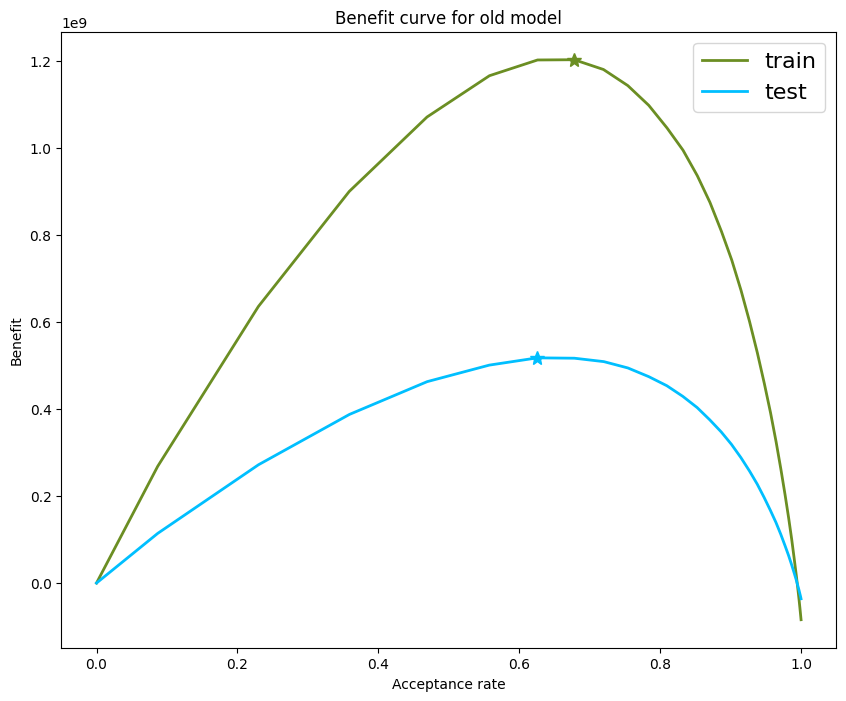

In [98]:
from sklearn.metrics import confusion_matrix
benefit_plot(lr, X_train, y_train, X_test, y_test)

### Неинтерпретируемая модель 



In [ ]:
benefit_plot(model_uint, X_train, y_train, X_test, y_test)

### LGD=80%

In [99]:
S = df['funded_amnt'].mean() # amount of loan
r = 0.15 # interest rate

lgd = 0.8 # losses in case of default

e_fp = r * S # profit if loan is returned
e_fn = lgd * S # loss if loan is gone



### Интерпретируемая модель 

Model train Max Benefit:  1411837078.008695
Model test Max Benefit:  607740500.3777745


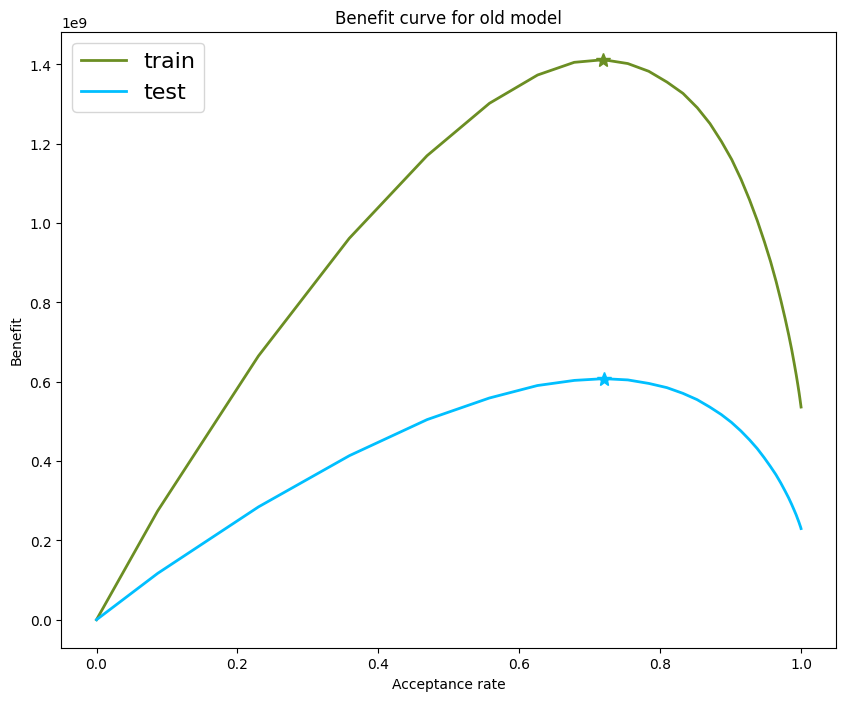

In [101]:
benefit_plot(lr, X_train, y_train, X_test, y_test)


### Неинтерпретируемая модель 

In [ ]:
benefit_plot(model_unint, X_train, y_train, X_test, y_test)
